In [4]:
import logging
import os
import sys
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from tqdm import tqdm

sys.path.append('../py')
from preprocess import preprocess
from models.defender_reach.preprocessor import DefenderReachDataset
from models.defender_reach.model import DefenderReachModel

LOG = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

RANDOM_SEED = 2
np.random.seed(RANDOM_SEED)

N_WEEKS = 18

In [5]:
##############  i. Load and preprocess the data ##############
sup_data = pd.read_csv('../data/supplementary_data.csv')
tracking_input, tracking_output = pd.DataFrame(), pd.DataFrame()
for week in tqdm(range(1, N_WEEKS+1), desc="Loading weekly data"):
    tracking_input = pd.concat([tracking_input, pd.read_csv(f'../data/train/input_2023_w{week:02d}.csv')], axis=0)
    tracking_output = pd.concat([tracking_output, pd.read_csv(f'../data/train/output_2023_w{week:02d}.csv')], axis=0)
LOG.info(f'Tracking input shape: {tracking_input.shape}, output shape: {tracking_output.shape}')

games, plays, players, tracking = preprocess.process_data(tracking_input, tracking_output, sup_data)
team_desc = preprocess.fetch_team_desc()

Loading weekly data: 100%|██████████| 18/18 [00:09<00:00,  1.83it/s]
2025-12-13 20:38:20,257 - INFO - Tracking input shape: (4880579, 23), output shape: (562936, 6)
2025-12-13 20:38:27,820 - INFO - Joined input and output tracking data: 14108 unique plays, 1384 unique nfl_ids
2025-12-13 20:38:27,821 - INFO - Standardizing direction of play and players to be left to right
2025-12-13 20:38:29,244 - INFO - Approximating missing speed, acceleration and direction values
2025-12-13 20:38:32,254 - INFO - Correlation results for imputations: s_approx: speed R²=0.9897 | a_approx: accel R²=0.0445 | dir_approx: dir R²=0.0442
2025-12-13 20:38:33,103 - INFO - Joining supplemental data to plays DataFrame
2025-12-13 20:38:33,142 - INFO - Loading NFL PBP data for season 2023
2025-12-13 20:38:33,143 - INFO - Loading pbp from local parquet file
2025-12-13 20:38:33,372 - INFO - Mapping player IDs to nfl_id using seasonal rosters
2025-12-13 20:38:33,373 - INFO - Rosters for season 2023 already cached, loa

In [6]:
##############  ii. Predict if defender is a part of the pass play ##############
ds = DefenderReachDataset()
defender_df = ds.generate_defender_data(tracking, plays)
model = DefenderReachModel()
if not model.check_is_trained():
    raise Exception("Defender Reach Model not trained. Run train_gnn_epa_model.py before running this script.")
model.load()
defender_df.loc[:, ['within_10_yards_proba', 'within_10_yards_pred']] = model.predict(defender_df)

defender_df = (defender_df
    .query('within_10_yards_pred==1')
    .reset_index(drop=True)
    .merge(
        players[['nfl_id','player_position']],
        on='nfl_id',
        how='left'
    )
)

gpids_with_over_4_defenders = (
    defender_df
        .drop_duplicates(subset=['gpid','nfl_id'])
        .groupby(['gpid']).size()
        .reset_index()
        .rename(columns={0:'n_defenders_involved'})
        .sort_values('n_defenders_involved', ascending=False)
        .query('n_defenders_involved > 4')
).gpid.unique()

# Drop the defender with the lowest probability of being within 10 yards on plays with over 4 defenders until 4 defenders remain
for gpid in tqdm(gpids_with_over_4_defenders, desc="Filtering plays with over 4 defenders"):
    df = defender_df.query('gpid==@gpid').copy()
    while df.shape[0] > 4:
        min_proba_idx = df['within_10_yards_proba'].idxmin()
        defender_df.drop(index=min_proba_idx, inplace=True)
        df = defender_df.query('gpid==@gpid').copy()

# Drop play if "S","FS","SS" not in defender positions
valid_positions = {'S', 'FS', 'SS'}
gpids_to_drop = []
for gpid in defender_df['gpid'].unique():
    positions = set(defender_df.query('gpid==@gpid')['player_position'].unique())
    if not positions.intersection(valid_positions):
        gpids_to_drop.append(gpid)
if gpids_to_drop:
    LOG.info(f"Dropping {len(gpids_to_drop)} plays with no safeties among defenders within 10 yards of the pass landing point")
    defender_df = defender_df[~defender_df['gpid'].isin(gpids_to_drop)].copy()

2025-12-13 20:39:59,764 - INFO - Dropping 2 plays with >4.0s ball airtime
2025-12-13 20:40:05,087 - INFO - Defender dataset built: 31891 rows, 12 cols
2025-12-13 20:40:05,232 - INFO - Trained model artifacts found.
2025-12-13 20:40:05,269 - INFO - Loaded model and metadata from /Users/lukeneuendorf/projects/nfl-big-data-bowl-2026/data/models/defender_reach
Filtering plays with over 4 defenders: 100%|██████████| 126/126 [00:00<00:00, 163.23it/s]
2025-12-13 20:40:29,813 - INFO - Dropping 6821 plays with no safeties among defenders within 10 yards of the pass landing point


In [11]:
##############  iii. Filter down to plays with free saftey data after the pass ##############

# Filters:
    # Safety must be in a free safety like position: at least 8 yards down field and within 10 yards of center field at time of snap
    # Pass distance must be at least 10 yards
    # Throw cannot be a "throw away": ball lands further than 5 yards from targeted receiver and qb threw outside of pocket
qb_outside_pocket = (
    tracking
    .query('pass_thrown and player_role=="Passer"')
    .sort_values('frame_id')
    .drop_duplicates(subset=['gpid'], keep='first')
    .rename(columns={'y':'qb_y_at_throw'})
    .merge(
        tracking.query('position=="Ball" and frame_id==1').rename(columns={'y':'ball_y_at_snap'})[['gpid','ball_y_at_snap']],
        on='gpid',
        how='left'
    )
    .assign(
        qb_outside_pocket=lambda x: np.abs(x['qb_y_at_throw'] - x['ball_y_at_snap']) > 7
    )
)
ball_receiver_distance = (
    tracking
    .sort_values('frame_id', ascending=False)
    .query('player_role=="Targeted Receiver"')
    [['gpid','x','y']]
    .rename(columns={'x':'receiver_x','y':'receiver_y'})
    .drop_duplicates(subset=['gpid'])
    .merge(
        tracking
        .sort_values('frame_id', ascending=False)
        .query('position=="Ball"')
        [['gpid','x','y']]
        .rename(columns={'x':'ball_x','y':'ball_y'})
        .drop_duplicates(subset=['gpid']),
        on='gpid',
        how='left'
    )
    .assign(
        ball_receiver_distance=lambda x: np.sqrt((x['ball_x'] - x['receiver_x'])**2 + (x['ball_y'] - x['receiver_y'])**2)
    )
    [['gpid','ball_receiver_distance']]
)
free_safties = (
    tracking.merge(
        defender_df[['gpid','nfl_id']],
        on=['gpid','nfl_id'],
        how='inner'
    )
    .query('frame_id == 1 and position in @valid_positions')
    .merge(
        plays[['gpid', 'pass_distance']],
        on='gpid',
        how='left'
    )
    .assign(
        downfield_distance=lambda x: x['x'],
        lateral_distance=lambda x: np.abs(x['y'] - 26.65)
    )
    .query('downfield_distance >= 8 and lateral_distance <= 10')
    .query('pass_distance >= 10')
    .merge(
        qb_outside_pocket[['gpid','qb_outside_pocket']],
        on='gpid',
        how='left'
    )
    .assign(
        qb_outside_pocket=lambda x: x['qb_outside_pocket'].fillna(False)
    )
    .merge(
        ball_receiver_distance[['gpid','ball_receiver_distance']],
        on='gpid',
        how='left'
    )
    .assign(
        is_throw_away=lambda x: (x['ball_receiver_distance'] > 5) & x['qb_outside_pocket']
    )
    .query('~is_throw_away')
    .reset_index(drop=True)
    [['gpid','nfl_id']]
)
LOG.info(f"Number of free safeties plays after filtering: {free_safties['gpid'].nunique()}")
LOG.info(f'Number of unique free safeties: {free_safties["nfl_id"].nunique()}')

2025-12-13 20:43:54,335 - INFO - Number of free safeties plays after filtering: 5135
2025-12-13 20:43:54,336 - INFO - Number of unique free safeties: 162


In [9]:
free_safties["nfl_id"].value_counts().reset_index().query('count >= 10')

,nfl_id,count
0,52613,99
1,53554,98
2,46123,97
3,44926,93
4,52453,90
...,...,...
121,46501,12
122,52512,11
123,54617,11
124,54962,10


In [12]:
free_safties

,gpid,nfl_id
0,2023090700_1001,47888
1,2023090700_1001,55910
2,2023090700_101,46137
3,2023090700_1154,46137
4,2023090700_1422,47888
...,...,...
5821,2024010713_3995,40166
5822,2024010713_4018,47844
5823,2024010713_599,40166
5824,2024010713_821,46259


In [37]:
defender_df

,gpid,game_id,nfl_id,x,y,dist_from_ball_land,approach_rate,lateral_rate,redirection_cost,seconds_in_air,last_dist_from_ball_land,within_10_yards,within_10_yards_proba,within_10_yards_pred,player_position
0,2023090700_1001,2023090700,44888,114.06,26.58,8.364860,-0.725208,0.598058,0.725208,1.2,6.445168,1,0.959719,1.0,OLB
1,2023090700_1001,2023090700,47888,114.79,28.30,6.551518,-0.762194,-1.245255,0.762194,1.2,4.809926,1,0.987810,1.0,SS
2,2023090700_1001,2023090700,53953,115.41,27.41,7.392705,-3.619277,-0.768658,3.619277,1.2,11.671948,0,0.611305,1.0,CB
3,2023090700_1001,2023090700,55910,111.27,42.52,8.856298,0.511624,2.324358,0.000000,1.2,4.850372,1,0.983874,1.0,SS
4,2023090700_101,2023090700,46137,55.82,17.67,19.375388,4.910060,2.099264,0.000000,2.1,4.865655,1,0.922851,1.0,SS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24889,2024010713_599,2024010713,46190,37.22,35.70,12.072192,3.993613,0.362159,0.000000,1.4,5.029404,1,0.990763,1.0,CB
24890,2024010713_599,2024010713,54554,42.81,25.88,11.574045,3.457155,-3.857523,0.000000,1.4,5.933043,1,0.982057,1.0,MLB
24892,2024010713_821,2024010713,46259,76.44,16.82,6.164479,2.342902,-2.309742,0.000000,0.7,3.842408,1,0.999913,1.0,SS
24893,2024010713_965,2024010713,40107,44.89,30.11,8.778002,3.702031,0.657699,0.000000,0.7,5.518932,1,0.999635,1.0,FS


In [39]:
(
    free_safties.merge(
        defender_df[['gpid','nfl_id','within_10_yards_proba']],
        how='left',
        on=['gpid','nfl_id']
    )
).within_10_yards_proba.describe()  

count    5826.000000
mean        0.922582
std         0.132427
min         0.432891
25%         0.916213
50%         0.988674
75%         0.998886
max         0.999997
Name: within_10_yards_proba, dtype: float64

In [13]:
plays.columns

Index(['gpid', 'game_id', 'play_id', 'absolute_yardline_number',
       'num_frames_output', 'ball_land_x', 'ball_land_y', 'season', 'week',
       'play_description', 'quarter', 'game_clock', 'down', 'yards_to_go',
       'possession_team', 'defensive_team', 'yardline_side', 'yardline_number',
       'pre_snap_home_score', 'pre_snap_visitor_score',
       'play_nullified_by_penalty', 'pass_result', 'pass_length',
       'offense_formation', 'receiver_alignment', 'route_of_targeted_receiver',
       'play_action', 'dropback_type', 'dropback_distance',
       'pass_location_type', 'defenders_in_the_box', 'team_coverage_man_zone',
       'team_coverage_type', 'penalty_yards', 'pre_penalty_yards_gained',
       'yards_gained_x', 'expected_points', 'expected_points_added',
       'pre_snap_home_team_win_probability',
       'pre_snap_visitor_team_win_probability',
       'home_team_win_probability_added', 'visitor_team_win_probility_added',
       'yards_gained_y', 'air_yards', 'yards_afte

In [14]:
free_safety_gpids = free_safties['gpid'].unique()
pass_times = plays.query('gpid in @free_safety_gpids').num_frames_output.div(10).add(1).values

count    5135.000000
mean        2.271704
std         0.558498
min         1.500000
25%         1.900000
50%         2.100000
75%         2.500000
max         5.000000
dtype: float64


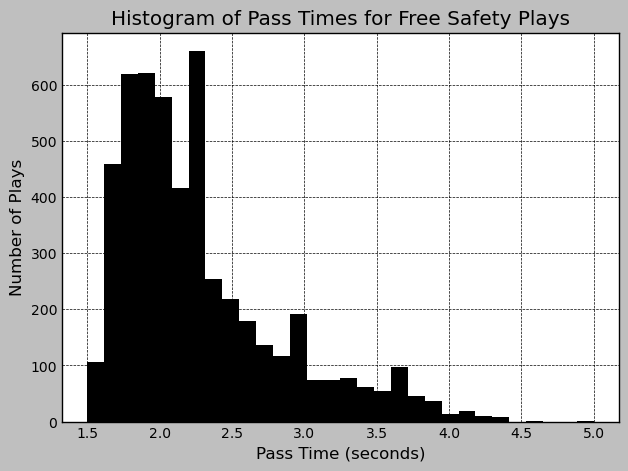

In [36]:
print(pd.Series(pass_times).describe())

# plot histogram of pass times
import matplotlib.pyplot as plt
# fivethirtyeight style
plt.style.use('grayscale')
plt.hist(pass_times, bins=30)
plt.xlabel('Pass Time (seconds)')
plt.ylabel('Number of Plays')
plt.title('Histogram of Pass Times for Free Safety Plays')
plt.show()

In [ ]:
# Find the safety coordinates one second before the throw
safety_starting_coords = (
    tracking.merge(
        free_safties,
        on=['gpid','nfl_id'],
        how='inner'
    )
    .merge(
        tracking
            .query('pass_thrown')
            [['gpid','frame_id']]
            .sort_values('frame_id', ascending=True)
            .drop_duplicates(subset=['gpid'], keep='first')
            .rename(columns={'frame_id':'throw_frame_id'}),
        on='gpid',
        how='left'
    )
    .assign(one_sec_before_throw_frame_id=lambda x: np.maximum(x['throw_frame_id'] - 10, 1))
    .query('frame_id == one_sec_before_throw_frame_id')
    .assign(
        vx=lambda x: x['s'] * np.cos(np.deg2rad(x['dir'])),
        vy=lambda x: x['s'] * np.sin(np.deg2rad(x['dir']))
    )
    .rename(columns={
        'x':'safety_start_x',
        'y':'safety_start_y',
        'dir':'safety_start_dir',
        's':'safety_start_s',
        'vx':'safety_start_vx',
        'vy':'safety_start_vy'
    })
    .merge(
        plays[['gpid','num_frames_output']],
        on='gpid',
        how='left'
    )
    .assign(
        pass_time=lambda x: (x['num_frames_output'] / 10.0) + 1.0  # Time from 1 second before throw to ball arrival
    )
    [['gpid','nfl_id','safety_start_x','safety_start_y','safety_start_dir','safety_start_s',
      'safety_start_vx','safety_start_vy','pass_time']]
    .reset_index(drop=True)
)

In [ ]:
##############  iv. Filter tracking data ###############
gpids = defender_df['gpid'].unique()
defender_gpid_nflids = set(defender_df['gpid'] + '_' + defender_df['nfl_id'].astype(str))
safety_gpids = free_safties['gpid'].unique()
df = (
    tracking
      .query('gpid in @gpids and gpid in @safety_gpids')
      .assign(gpid_nflid=lambda x: x['gpid'] + '_' + x['nfl_id'].astype(str))
      .query('gpid_nflid in @defender_gpid_nflids or position=="Ball" or player_role=="Targeted Receiver"')
      .merge(
          plays[['gpid','ball_land_x','ball_land_y','team_coverage_man_zone',
                 'route_of_targeted_receiver']],
          on='gpid',
          how='left'
      )
      .assign(
          zone_coverage=lambda x: np.where(x['team_coverage_man_zone'] == "ZONE_COVERAGE", 1, 0),
          route_type=lambda x: np.select(
                [
                    x['route_of_targeted_receiver'].isin(['GO', 'POST', 'CORNER', 'WHEEL']),
                    x['route_of_targeted_receiver'].isin(['IN', 'SLANT', 'CROSS', 'ANGLE']),
                    x['route_of_targeted_receiver'].isin(['OUT']),
                    x['route_of_targeted_receiver'].isin(['HITCH', 'FLAT', 'SCREEN'])
                ],
                [
                    'VERTICAL',
                    'INSIDE_BREAK',
                    'OUTSIDE_BREAK',
                    'UNDERNEATH_SHORT'
                ],
                default='OTHER'
            )
      )
      .merge(
          tracking
            .query('pass_thrown')
            .groupby('gpid')['frame_id'].max()
            .reset_index()
            .rename(columns={'frame_id':'ball_land_frame_id'})
            [['gpid','ball_land_frame_id']],
          on='gpid',
          how='left'
      )
      .query('frame_id == ball_land_frame_id')
      .merge(
          defender_df[['gpid','nfl_id','within_10_yards_proba']],
          on=['gpid','nfl_id'],
          how='left'
      )
      [['gpid', 'frame_id', 'nfl_id', 'player_role', 'position', 'x', 'y', 's', 'dir',
        'ball_land_x','ball_land_y','zone_coverage','within_10_yards_proba',
        'route_vertical','route_inside_break','route_outside_break','route_underneath_short']]
      .merge(
          plays[['gpid', 'yards_to_go', 'down', 'absolute_yardline_number', 'pass_distance']],
          on='gpid',
          how='left'
      )
      .sort_values(['gpid','player_role','within_10_yards_proba'], ascending=[True, True, False])
      .assign(
          vx=lambda x: x['s'] * np.cos(np.deg2rad(x['dir'])),
          vy=lambda x: x['s'] * np.sin(np.deg2rad(x['dir'])),
          ball_land_yards_to_first_down=lambda x: np.maximum(x['yards_to_go'] - x['ball_land_x'], 0),
          ball_land_yards_to_endzone=lambda x: np.maximum(110 - (x['absolute_yardline_number'] + x['ball_land_x']), 0)
      )
)